<a href="https://colab.research.google.com/github/joaomigueld3/natural-language-processing/blob/main/PLN_Movie_Genre_Classification_Jo%C3%A3o_Miguel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
!pip install pandas numpy spacy scikit-learn matplotlib seaborn


In [1]:
# @title
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [2]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title
# df = pd.read_csv('/content/drive/MyDrive/DatasetsColab/movies_overview.csv')
df = pd.read_csv('/content/drive/MyDrive/DatasetsColab/movies_overview.csv', sep=",", header=0)

In [11]:
genres_df = pd.read_csv('/content/drive/MyDrive/DatasetsColab/movies_genres.csv')

In [21]:
# @title
# Visualizing first lines
print('movies:', df.head())
print('\ngenres:', genres_df.head())

movies:                       title  \
0  The Shawshank Redemption   
1             The Godfather   
2     The Godfather Part II   
3          Schindler's List   
4              12 Angry Men   

                                            overview        genre_ids  
0  Imprisoned in the 1940s for the double murder ...         [18, 80]  
1  Spanning the years 1945 to 1955, a chronicle o...         [18, 80]  
2  In the continuing saga of the Corleone crime f...         [18, 80]  
3  The true story of how businessman Oskar Schind...  [18, 36, 10752]  
4  The defense and the prosecution have rested an...             [18]  

genres:    id       name
0  28     Action
1  12  Adventure
2  16  Animation
3  35     Comedy
4  80      Crime


In [22]:
print('movies:', df.columns)
print('genre:', genres_df.columns)

movies: Index(['title', 'overview', 'genre_ids'], dtype='object')
genre: Index(['id', 'name'], dtype='object')


In [16]:
# Cria o dicionário de mapeamento
genre_map = dict(zip(genres_df['id'], genres_df['name']))
print('genre dict:',genre_map)

genre dict: {28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


In [26]:
import ast  # para transformar string '[28, 12]' em lista [28, 12]

# Função para mapear ids para nomes
def map_genre_ids_to_names(genre_ids_str):
    try:
        genre_ids = ast.literal_eval(genre_ids_str)
        return [genre_map.get(genre_id, "Unknown") for genre_id in genre_ids]
    except:
        return []

# Cria nova coluna com nomes dos gêneros
df['genre_names'] = df['genre_ids'].apply(map_genre_ids_to_names)

# Visualiza
print(df[['title', 'genre_ids', 'genre_names']].head())


                      title        genre_ids            genre_names
0  The Shawshank Redemption         [18, 80]         [Drama, Crime]
1             The Godfather         [18, 80]         [Drama, Crime]
2     The Godfather Part II         [18, 80]         [Drama, Crime]
3          Schindler's List  [18, 36, 10752]  [Drama, History, War]
4              12 Angry Men             [18]                [Drama]


In [30]:
# @title
# Check about data types and null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        9980 non-null   object
 1   overview     9980 non-null   object
 2   genre_ids    9980 non-null   object
 3   genre_names  9980 non-null   object
dtypes: object(4)
memory usage: 312.0+ KB
None


In [39]:
# @title
# Descriptive Statistics
print(df.describe())

         title                                           overview genre_ids  \
count     9980                                               9980      9980   
unique    9615                                               9971      2222   
top     Return  Young businessman Thomas Crown is bored and de...      [18]   
freq        13                                                  2       577   

       genre_names  
count         9980  
unique        2222  
top        [Drama]  
freq           577  


In [32]:
# @title
# Checking for Null Values
print(df.isnull().sum())

title          0
overview       0
genre_ids      0
genre_names    0
dtype: int64


In [41]:
# @title
# Remove spaces from column names
df.columns = df.columns.str.strip()
print(df.columns)

Index(['title', 'overview', 'genre_ids', 'genre_names'], dtype='object')


### Exploratory Data Analysis (EDA) - Análise Exploratória de Dados

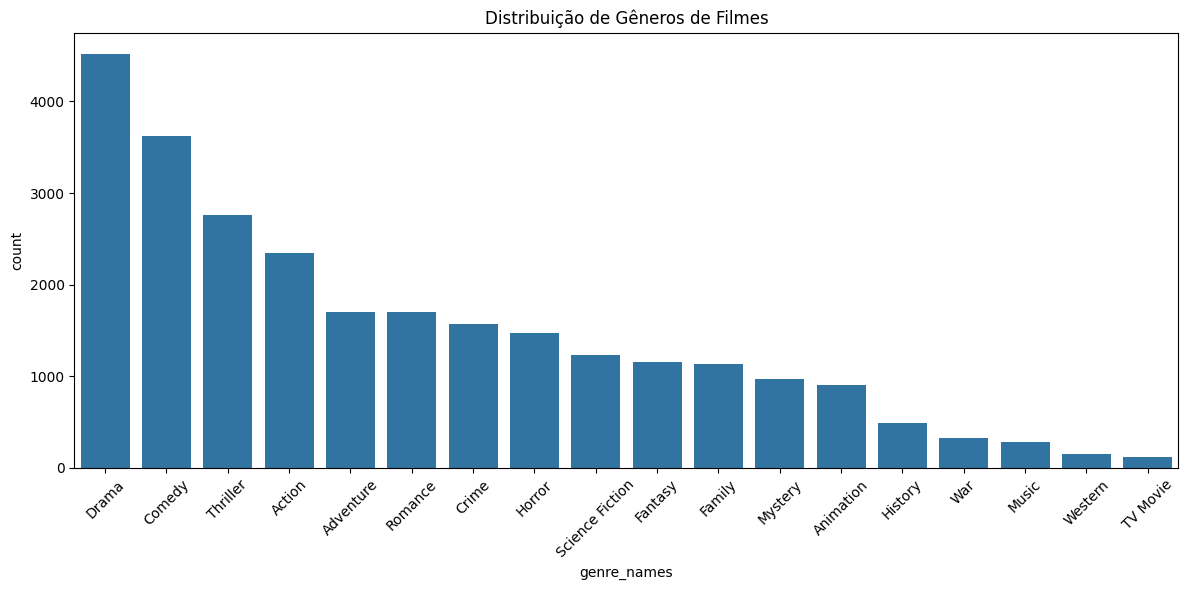

In [42]:
# Remove valores nulos ou vazios antes de contar
genre_exploded = df.explode('genre_names')
genre_exploded = genre_exploded[genre_exploded['genre_names'].notna() & (genre_exploded['genre_names'] != '')]

# Garante que os rótulos sejam únicos na ordenação
genre_counts = genre_exploded['genre_names'].value_counts().reset_index()
genre_counts.columns = ['genre_names', 'count']

# Gráfico corrigido
plt.figure(figsize=(12,6))
sns.countplot(data=genre_exploded, x='genre_names', order=genre_counts['genre_names'])
plt.title('Distribuição de Gêneros de Filmes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Aqui vemos quais gêneros aparecem com mais frequência. Isso é importante para evitar desbalanceamento de classes no modelo de machine learning.

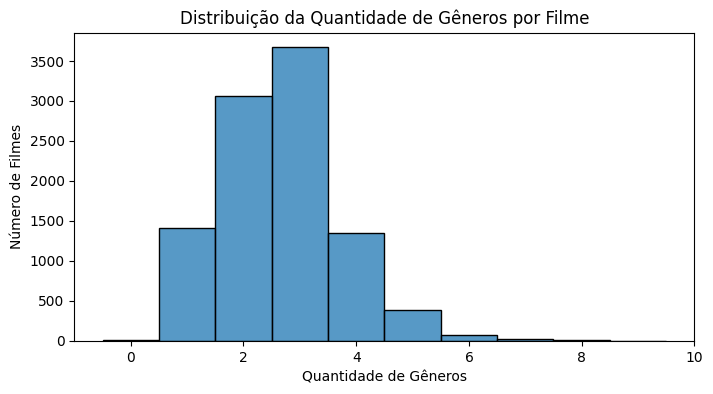

In [43]:
df['num_genres'] = df['genre_names'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df['num_genres'], bins=range(1, df['num_genres'].max()+2), discrete=True)
plt.title("Distribuição da Quantidade de Gêneros por Filme")
plt.xlabel("Quantidade de Gêneros")
plt.ylabel("Número de Filmes")
plt.show()


A maioria dos filmes tem entre 1 e 3 gêneros. Filmes com muitos gêneros são menos comuns.

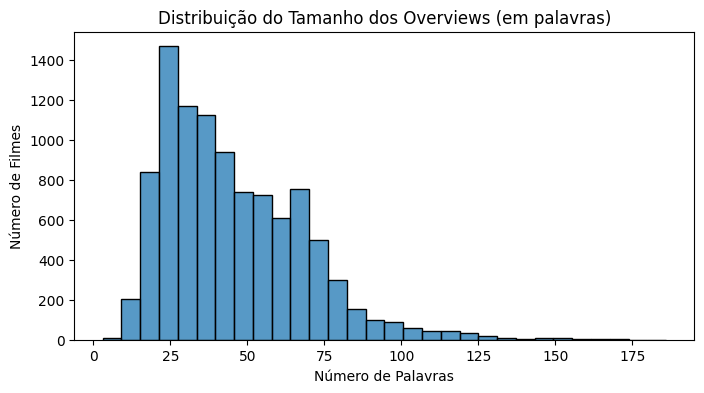

In [44]:
df['overview_length'] = df['overview'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
sns.histplot(df['overview_length'], bins=30)
plt.title("Distribuição do Tamanho dos Overviews (em palavras)")
plt.xlabel("Número de Palavras")
plt.ylabel("Número de Filmes")
plt.show()


A maioria dos overviews tem entre 30 e 120 palavras. Importante para avaliar o impacto do TfidfVectorizer.

## Preprocessing with SpaCy

In [51]:
# @title
# Baixar modelo do SpaCy para inglês
import spacy
nlp = spacy.load('en_core_web_sm')

# Função para pré-processamento
def preprocess(text):
    doc = nlp(text.lower())  # Converter para minúsculas
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_stop])

# Aplicar pré-processamento ao dataset
df["text_processed"] = df["overview"].apply(preprocess)

# Visualizar os dados processados
print(df[["overview", "text_processed"]].head())


                                            overview  \
0  Imprisoned in the 1940s for the double murder ...   
1  Spanning the years 1945 to 1955, a chronicle o...   
2  In the continuing saga of the Corleone crime f...   
3  The true story of how businessman Oskar Schind...   
4  The defense and the prosecution have rested an...   

                                      text_processed  
0  imprison 1940 double murder wife lover upstand...  
1  span year 1945 1955 chronicle fictional italia...  
2  continue saga corleone crime family young vito...  
3  true story businessman oskar schindler save th...  
4  defense prosecution rest jury file jury room d...  


### Extrair gênero principal

In [54]:
df['main_genre'] = df['genre_names'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown')

# Remover entradas sem gênero conhecido
df = df[df['main_genre'] != 'Unknown']

## Convert text to TF-IDF vectors

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text_processed"])
y = df["main_genre"]

# Converter os rótulos em valores numéricos
y = df["title"]

# Exibir algumas palavras do vocabulário TF-IDF
print("Palavras no vocabulário:", vectorizer.get_feature_names_out()[:100])


Palavras no vocabulário: ['000' '10' '100' '11' '12' '13' '14' '15' '16' '16th' '17' '17th' '18'
 '1890s' '18th' '19' '1920s' '1930' '1930s' '1940' '1941' '1942' '1943'
 '1944' '1945' '1950' '1950s' '1957' '1959' '1960' '1962' '1963' '1964'
 '1965' '1967' '1969' '1970' '1970s' '1971' '1972' '1973' '1976' '1977'
 '1978' '1979' '1980' '1980s' '1984' '1987' '1988' '1990' '1991' '1999'
 '19th' '20' '200' '2008' '2009' '20th' '21' '21st' '22' '23' '24' '25'
 '26' '27' '28' '30' '300' '35' '40' '400' '47' '50' '500' '60' '70' '80'
 '90' 'aaron' 'abandon' 'abby' 'abduct' 'abduction' 'ability' 'able'
 'aboard' 'abroad' 'abruptly' 'absence' 'absent' 'absorb' 'abuse'
 'abusive' 'academic' 'academy' 'accept' 'access' 'accident']


In [49]:
df = df[df['main_genre'] != 'Unknown']

In [60]:
# @title
# Imprime a representação TF-IDF do corpus
print("Matriz TF-IDF:")
print(X.toarray())

Matriz TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [64]:
# @title
num_palavras = len(vectorizer.get_feature_names_out())
print(num_palavras)

5000


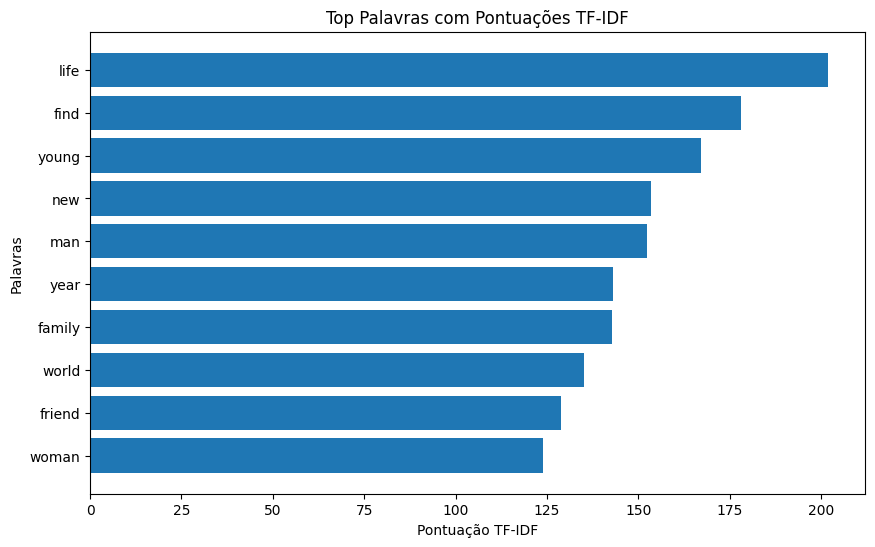

In [65]:
# @title
import numpy as np  # Certifique-se de importar numpy
import matplotlib.pyplot as plt

# Visualizar os valores TF-IDF
# Vamos identificar as palavras mais relevantes do corpus usando TF-IDF
def plot_tfidf(matrix, feature_names, top_n=10):
    # Calcula a soma das pontuações TF-IDF para cada palavra
    tfidf_sums = np.array(matrix.sum(axis=0)).flatten()
    top_indices = tfidf_sums.argsort()[-top_n:][::-1]

    # Palavras mais relevantes
    top_words = [feature_names[i] for i in top_indices]
    top_scores = tfidf_sums[top_indices]

    # Criar o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_scores, align='center')
    plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar os scores em ordem decrescente
    plt.title("Top Palavras com Pontuações TF-IDF")
    plt.xlabel("Pontuação TF-IDF")
    plt.ylabel("Palavras")
    plt.show()

# Visualizar palavras mais relevantes no corpus
plot_tfidf(X, vectorizer.get_feature_names_out(), top_n=10)

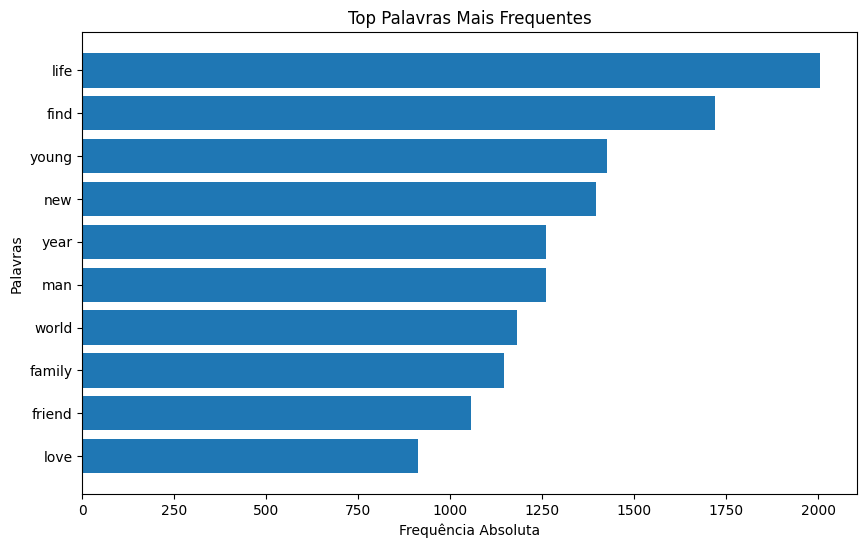

In [66]:
from collections import Counter
import matplotlib.pyplot as plt

# Função para contar as palavras mais frequentes no corpus
def plot_word_frequency(corpus_processed, top_n=10):
    # Unir todos os documentos do corpus em um único texto
    all_words = " ".join(corpus_processed).split()

    # Contar a frequência de cada palavra
    word_counts = Counter(all_words)

    # Selecionar as palavras mais frequentes
    most_common = word_counts.most_common(top_n)
    top_words = [word for word, count in most_common]
    top_counts = [count for word, count in most_common]

    # Criar o gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_counts, align='center')
    plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar as palavras em ordem decrescente
    plt.title("Top Palavras Mais Frequentes")
    plt.xlabel("Frequência Absoluta")
    plt.ylabel("Palavras")
    plt.show()

# Chamando a função para exibir as palavras mais frequentes
plot_word_frequency(df["text_processed"], top_n=10)

## Split Data for Training and Testing

In [63]:
# Dividir em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Tamanho do conjunto de treino: (7981, 5000)
Tamanho do conjunto de teste: (1996, 5000)


## Training a Machine Learning Model


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Separar os dados
X_train, X_test, y_train, y_test = train_test_split(
    df['text_processed'], df['main_genre'], test_size=0.2, random_state=42)

In [71]:
# Dicionário de modelos
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': LinearSVC(),
    'Random Forest': RandomForestClassifier()
}

# Inicializando o vetor TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Ajustando e transformando os dados de treinamento
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transformando os dados de teste
X_test_tfidf = vectorizer.transform(X_test)

# Treinando e avaliando cada modelo
for name, model in models.items():
    print(f"Treinando modelo: {name}")

    # Treinamento
    model.fit(X_train_tfidf, y_train)

    # Predição
    y_pred = model.predict(X_test_tfidf)

    # Avaliação
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} - Acurácia: {accuracy:.2f}')
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")


Treinando modelo: Naive Bayes
Naive Bayes - Acurácia: 0.36
                 precision    recall  f1-score   support

         Action       0.50      0.36      0.42       287
      Adventure       0.00      0.00      0.00       103
      Animation       0.00      0.00      0.00       127
         Comedy       0.41      0.65      0.50       395
          Crime       0.00      0.00      0.00        84
          Drama       0.31      0.84      0.45       426
         Family       0.00      0.00      0.00        50
        Fantasy       0.00      0.00      0.00        44
        History       0.00      0.00      0.00        11
         Horror       0.67      0.05      0.09       167
          Music       0.00      0.00      0.00        16
        Mystery       0.00      0.00      0.00        29
        Romance       0.00      0.00      0.00        66
Science Fiction       0.00      0.00      0.00        56
       TV Movie       0.00      0.00      0.00         1
       Thriller       0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression - Acurácia: 0.43
                 precision    recall  f1-score   support

         Action       0.42      0.56      0.48       287
      Adventure       0.33      0.06      0.10       103
      Animation       0.47      0.14      0.22       127
         Comedy       0.44      0.72      0.55       395
          Crime       0.20      0.05      0.08        84
          Drama       0.41      0.72      0.52       426
         Family       0.00      0.00      0.00        50
        Fantasy       0.00      0.00      0.00        44
        History       0.00      0.00      0.00        11
         Horror       0.58      0.49      0.53       167
          Music       0.00      0.00      0.00        16
        Mystery       0.00      0.00      0.00        29
        Romance       0.00      0.00      0.00        66
Science Fiction       0.13      0.04      0.06        56
       TV Movie       0.00      0.00      0.00         1
       Thriller       0.60      0.03      0.05    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Support Vector Machine - Acurácia: 0.42
                 precision    recall  f1-score   support

         Action       0.45      0.53      0.49       287
      Adventure       0.29      0.22      0.25       103
      Animation       0.38      0.26      0.31       127
         Comedy       0.47      0.63      0.53       395
          Crime       0.15      0.10      0.12        84
          Drama       0.45      0.59      0.51       426
         Family       0.37      0.14      0.20        50
        Fantasy       0.17      0.05      0.07        44
        History       0.00      0.00      0.00        11
         Horror       0.47      0.52      0.49       167
          Music       0.33      0.06      0.11        16
        Mystery       0.00      0.00      0.00        29
        Romance       0.21      0.06      0.09        66
Science Fiction       0.25      0.23      0.24        56
       TV Movie       0.00      0.00      0.00         1
       Thriller       0.24      0.11      0.15 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest - Acurácia: 0.36
                 precision    recall  f1-score   support

         Action       0.39      0.50      0.44       287
      Adventure       0.25      0.01      0.02       103
      Animation       0.45      0.08      0.13       127
         Comedy       0.36      0.55      0.43       395
          Crime       0.25      0.02      0.04        84
          Drama       0.33      0.65      0.44       426
         Family       1.00      0.02      0.04        50
        Fantasy       0.00      0.00      0.00        44
        History       0.00      0.00      0.00        11
         Horror       0.47      0.40      0.43       167
          Music       0.00      0.00      0.00        16
        Mystery       0.00      0.00      0.00        29
        Romance       0.00      0.00      0.00        66
Science Fiction       0.15      0.04      0.06        56
       TV Movie       0.00      0.00      0.00         1
       Thriller       0.00      0.00      0.00       105

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression foi o melhor desempenho geral, com acurácia de 43%.

O Support Vector Machine (SVM) ficou muito próximo, com 42%, pode indicar que modelos lineares têm boa capacidade de generalização nesse problema.

Naive Bayes e Random Forest foram os piores com 36%, possivelmente devido à natureza do texto e à alta dimensionalidade do espaço vetorial criado pelo TF-IDF.

Macro avg (média entre classes) foram baixas para todos os modelos, o que sugere desequilíbrio de classes (alguns gêneros aparecem muito mais que outros).

As médias weighted avg também mostram que os modelos estão inclinados a prever os gêneros mais frequentes, prejudicando os menos comuns.

Possíveis motivos para dificuldade me prever gÊnero de filmes a partir do resumo:
A sobreposição semântica entre gêneros (ex: Drama, Romance, Thriller);
Vocabulário genérico utilizados nos resumos;
A possível ambiguidade ou múltiplos gêneros representados por um único texto;